Вариант 12

Лабораторная работа №1: Оценка точности модели снепрерывной зависимой переменной
В практических примерах ниже показано:

как делить данные на выборки (обучающую и тестовую);

как считать MSE: среднеквадратическую ошибку модели;

как меняются MSE на тестовой и обучающей выборках с изменением гибкости (числа степеней свободы) модели.

Модели: сглаживающие сплайны.

Данные: сгенерированные.

F(X) = 18 - 0.1 * x.

Изменяемая характеристика: sigma (2.5, 2, 1.5).

Задача 1. На данных своего варианта повторить расчёты и построить графики из первой лабораторной.
Пояснить выбор наилучшего количества степеней свободы.

Задача 2. Повторить расчёты, меняя характеристики согласно своему варианту.
Проанализировать, как меняется MSE при изменении характеристик.

Задача 1: Решение.
1. Зададим исходные данные и функцию. Построим по ним обучающую и тестирующую выборки. Представим исходные данные на графике.
2. Построим при помощи библиотеки R сплайны на обучающей выборке для df = 38. Проверим MSE значение для обучающей и тестирующей выборок. Представим полученный сплайн на графике с исходной функцией.
3. Опробуем разные значения df [2, 40] и найдем такое, при котором тестовое MSE значение будет наименьшим. Представим на графике обучающие и тестовые MSE значения для разных значений df.

In [1]:
# загрузка пакетов
import numpy as np
import random

In [2]:
# задаём ядро генератора случайных чисел (внимание: не глобально)
np.random.seed(10111)

# всего наблюдений, доля обучающей выборки
n_all, train_percent = 60, 0.85

# параметры распределения X
x_min, x_max = 5, 105

# генерируем X
x = np.random.uniform(x_min, x_max, n_all)

# генерируем случайный шум
mu, sigma = 0, 1
res = np.random.normal(mu, sigma, n_all)

# отбираем наблюдения в обучающую выборку
in_train = np.random.choice(np.arange(n_all), int(n_all * train_percent), replace = False)

# истинная функция взаимосвязи
def y_func(x):
  return 18 - 0.1 * x

# для графика истинной взаимосвязи
x_line = np.linspace(x_min, x_max, n_all)
y_line = y_func(x_line)

# фактические значения y (с шумом)
y = y_func(x) + res

# создаём векторы с данными для построения графиков
# наблюдения на обучающей выборке
x_train = x[in_train]
y_train = y[in_train]

# наблюдения на тестовой выборке
x_test = np.delete(x, in_train)
y_test = np.delete(y, in_train)

In [3]:
# загрузка пакетов
import matplotlib.pyplot as plt

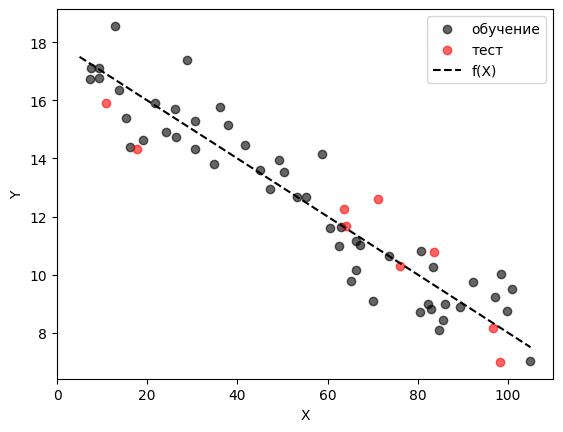

In [4]:
# график 1: исходные данные
# обучающая выборка
plt.scatter(x_train, y_train, c = "black", label = "обучение", alpha = 0.6)
# тестовая выборка
plt.scatter(x_test, y_test, c = "red", label = "тест", alpha = 0.6)
# подписи осей
plt.plot(x_line, y_line, c = "black", linestyle = "dashed", label = "f(X)")
plt.xlabel("X")
plt.ylabel("Y")
# легенда
plt.legend()
plt.show()

In [5]:
# загрузка пакетов
from pandas import DataFrame
import rpy2.robjects as robjects

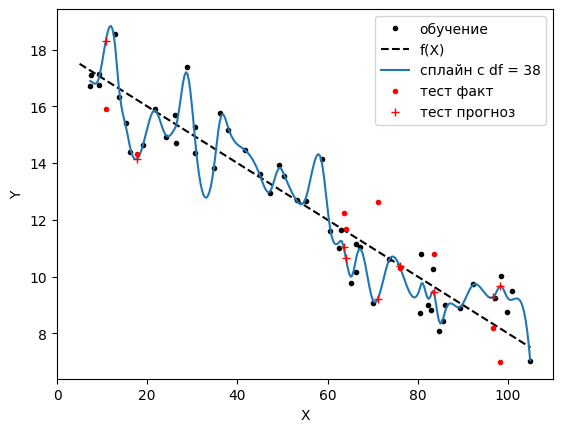

In [6]:
# модель натурального сплайна с заданным количеством узлов (df)
my_df = 38

# сохраняем индексы отсортированного по возрастанию x из обучающей выборки
x_sorted_index = sorted(range(len(x_train)), key = lambda k: x_train[k])

# равноотстоящие координаты по X для прорисовки сглаженной кривой
x_train_lin = np.linspace(min(x_train), max(x_train), num = 300, endpoint = True)

# создаём из данных объекты, понятные R
r_x = robjects.FloatVector(x_train)
r_y = robjects.FloatVector(y_train)

# импортируем нужную функцию из R
r_smooth_spline = robjects.r["smooth.spline"]

# строим сглаживающий сплайн
fit = r_smooth_spline(x = r_x, y = r_y, df = my_df)

# делаем прогнозы
y_hat_train = np.array(robjects.r["predict"](fit, robjects.FloatVector(x_train)).rx2("y"))
y_hat_test = np.array(robjects.r["predict"](fit, robjects.FloatVector(x_test)).rx2("y"))
y_lin_plot = np.array(robjects.r["predict"](fit, robjects.FloatVector(x_train_lin)).rx2("y"))

# строим график
plt.plot(x_train, y_train, color = "black", ls = "", marker = ".", label = "обучение")
plt.plot(x_line, y_line, color = "black", ls = "dashed", marker = "", label = "f(X)")
plt.plot(x_train_lin, y_lin_plot, marker = "", label = f"сплайн с df = {my_df}")
plt.plot(x_test, y_test, color = "red", ls = "", marker = ".", label = "тест факт")
plt.plot(x_test, y_hat_test, color = "red", ls = "", marker = "+", label = "тест прогноз")
# подписи осей
plt.xlabel("X")
plt.ylabel("Y")
# легенда
plt.legend(loc = "best")

# считаем MSE
MSE_fit = [sum((y_train - y_hat_train) ** 2) / len(y_train),
           sum((y_test - y_hat_test) ** 2) / len(y_test)]

In [7]:
# выводим MSE с округлением
np.around(MSE_fit, 2)

array([0.11, 3.32])

In [8]:
# модели с df от 2 до 40 #

# максимальное число степеней свободы для модели сплайна
max_df = 40

# фрейм данных для сохранения MSE на обучающей и на тестовой
# при разных степенях свободы
MSE_all_dfs = [[0] * 2 for i in range(2, max_df + 1)]
MSE_all_dfs = DataFrame(MSE_all_dfs, columns = ["MSE_train", "MSE_test"], index = list(range(2, max_df + 1)))

# заполняем фрейм
for i_df in range(2, max_df + 1):
  # обучаем модель
  fit = r_smooth_spline(x = r_x, y = r_y, df = i_df)

  # прогноз на обучающей выборке
  y_train_hat = np.array(robjects.r["predict"](fit, robjects.FloatVector(x_train)).rx2("y"))
  # прогноз на тестовой выборке
  y_test_hat = np.array(robjects.r["predict"](fit, robjects.FloatVector(x_test)).rx2("y"))

  # считаем MSE
  MSE_all_dfs.loc[i_df, "MSE_train"] = sum((y_train - y_train_hat) ** 2) / len(y_train_hat)
  MSE_all_dfs.loc[i_df, "MSE_test"] = sum((y_test - y_test_hat) ** 2) / len(y_test_hat)

In [9]:
# фильтруем таблицу по минимальной MSE на тестовой выборке
MSE_all_dfs[MSE_all_dfs["MSE_test"] == min(MSE_all_dfs["MSE_test"])]

,MSE_train,MSE_test
2,0.995238,1.125504


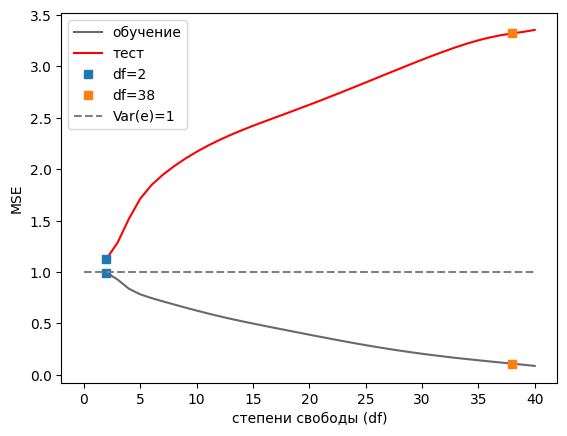

In [10]:
# график изменения MSE с увеличением df
plt.plot(MSE_all_dfs.index, MSE_all_dfs["MSE_train"], color = "dimgrey", marker = "", label = "обучение")
plt.plot(MSE_all_dfs.index, MSE_all_dfs["MSE_test"], color = "red", marker = "", label = "тест")
plt.plot([2, 2], [MSE_all_dfs.iloc[0]["MSE_train"], MSE_all_dfs.iloc[0]["MSE_test"]], ls = "", marker = "s", label = "df=2")
plt.plot([38, 38], [MSE_all_dfs.iloc[36]["MSE_train"], MSE_all_dfs.iloc[36]["MSE_test"]], ls = "", marker = "s", label = "df=38")
plt.hlines(1, 0, 40, linestyles = "dashed", color = "grey", label = "Var(e)=1")
# подписи осей
plt.xlabel("степени свободы (df)")
plt.ylabel("MSE")
# легенда
plt.legend(loc = "best")
plt.show()

Задача 1: Результаты.
1. При переборе разных значений df мы определили, что для  функции f(X) = 18 - 0.1 * x лучшее значение df = 2. Это значение является интуитивным, так как функция представляет собой прямую, для описания которой достаточно только двух точек. При df > 2 сплайн будет фокусироваться только на обучающих данных и вредить представлению тестовых данных.
2. При df = 2 обучающее MSE близко к 1, что выражает заданное отклонение sigma = 1. Тестовое MSE равно 1.13, что соответствует sigma^ = 1.06.

Задача 2: Решение.
1. Повторим перебор df значений [2; 40] из Задачи 1 для разных значений sigma [1.5, 2, 2.5]. Полученные значения сохраним в фрейм (формой 38x6), и выберем для каждого sigma такое df, чтобы тестовое MSE было наименьшим. Представим графики обучающих и тестовых MSE для разных df и для разных sigma, выделяя точки с наименьшим тестовым MSE.

In [11]:
# задаём ядро генератора случайных чисел
np.random.seed(10111)

# создаем фрейм для хранения MSE при разных сигмах
MSE_all_dfs = [[0] * 6 for i in range(2, max_df + 1)]
MSE_all_dfs = DataFrame(MSE_all_dfs, columns = ["MSE_train (s = 1.5)", "MSE_test (s = 1.5)", "MSE_train (s = 2.0)", "MSE_test (s = 2.0)", "MSE_train (s = 2.5)", "MSE_test (s = 2.5)"], index = list(range(2, max_df + 1)))

# определяем значения сигма и создаем итерацию для каждого значения
sigmas = [1.5, 2.0, 2.5]
for sigma in sigmas:
  # определим случайное распределение для текущего значения
  mu = 0
  res = np.random.normal(mu, sigma, n_all)

  # определим y-данные с учетом текущей сигмы (x-данные будут общими для всех итераций и берутся из задания 1)
  y = y_func(x) + res
  y_train = y[in_train]
  y_test = np.delete(y, in_train)
  r_y = robjects.FloatVector(y_train)

  # собираем данные для каждой степени свободы
  for i_df in range(2, max_df + 1):
    # строим сплайн
    fit = r_smooth_spline(x = r_x, y = r_y, df = i_df)

    # прогноз на обучающей выборке
    y_train_hat = np.array(robjects.r["predict"](fit, robjects.FloatVector(x_train)).rx2("y"))
    # прогноз на тестовой выборке
    y_test_hat = np.array(robjects.r["predict"](fit, robjects.FloatVector(x_test)).rx2("y"))

    # считаем MSE и записываем его в фрейм
    MSE_all_dfs.loc[i_df, f"MSE_train (s = {sigma})"] = sum((y_train - y_train_hat) ** 2) / len(y_train_hat)
    MSE_all_dfs.loc[i_df, f"MSE_test (s = {sigma})"] = sum((y_test - y_test_hat) ** 2) / len(y_test_hat)

In [12]:
# число степеней свободы для минимальной ошибки тестирования (сигма = 1.5)
MSE_all_dfs[MSE_all_dfs["MSE_test (s = 1.5)"] == min(MSE_all_dfs["MSE_test (s = 1.5)"])][["MSE_train (s = 1.5)", "MSE_test (s = 1.5)"]]

,MSE_train (s = 1.5),MSE_test (s = 1.5)
26,0.450424,3.494723


In [13]:
# число степеней свободы для минимальной ошибки тестирования (сигма = 2.0)
MSE_all_dfs[MSE_all_dfs["MSE_test (s = 2.0)"] == min(MSE_all_dfs["MSE_test (s = 2.0)"])][["MSE_train (s = 2.0)", "MSE_test (s = 2.0)"]]

,MSE_train (s = 2.0),MSE_test (s = 2.0)
2,3.698501,5.423706


In [14]:
# число степеней свободы для минимальной ошибки тестирования (сигма = 2.5)
MSE_all_dfs[MSE_all_dfs["MSE_test (s = 2.5)"] == min(MSE_all_dfs["MSE_test (s = 2.5)"])][["MSE_train (s = 2.5)", "MSE_test (s = 2.5)"]]

,MSE_train (s = 2.5),MSE_test (s = 2.5)
2,4.62766,6.406831


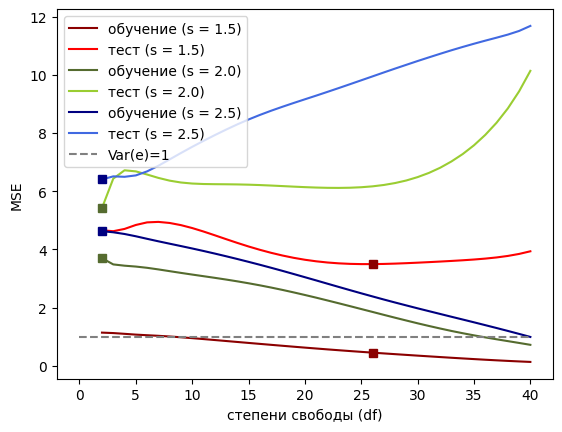

In [15]:
# графики изменения MSE с увеличением df (обучение - темный график, тестирование - светлый график)
# графики для сигма = 1.5 (красный цвет)
plt.plot(MSE_all_dfs.index, MSE_all_dfs["MSE_train (s = 1.5)"], color = "darkred", marker = "", label = "обучение (s = 1.5)")
plt.plot(MSE_all_dfs.index, MSE_all_dfs["MSE_test (s = 1.5)"], color = "red", marker = "", label = "тест (s = 1.5)")
plt.plot([26, 26], [MSE_all_dfs.iloc[24]["MSE_train (s = 1.5)"], MSE_all_dfs.iloc[24]["MSE_test (s = 1.5)"]], color = "darkred", ls = "", marker = "s")
# графики для сигма = 2.0 (зеленый цвет)
plt.plot(MSE_all_dfs.index, MSE_all_dfs["MSE_train (s = 2.0)"], color = "darkolivegreen", marker = "", label = "обучение (s = 2.0)")
plt.plot(MSE_all_dfs.index, MSE_all_dfs["MSE_test (s = 2.0)"], color = "yellowgreen", marker = "", label = "тест (s = 2.0)")
plt.plot([2, 2], [MSE_all_dfs.iloc[0]["MSE_train (s = 2.0)"], MSE_all_dfs.iloc[0]["MSE_test (s = 2.0)"]], color = "darkolivegreen", ls = "", marker = "s")
# графики для сигма = 2.5 (синий цвет)
plt.plot(MSE_all_dfs.index, MSE_all_dfs["MSE_train (s = 2.5)"], color = "navy", marker = "", label = "обучение (s = 2.5)")
plt.plot(MSE_all_dfs.index, MSE_all_dfs["MSE_test (s = 2.5)"], color = "royalblue", marker = "", label = "тест (s = 2.5)")
plt.plot([2, 2], [MSE_all_dfs.iloc[0]["MSE_train (s = 2.5)"], MSE_all_dfs.iloc[0]["MSE_test (s = 2.5)"]], color = "navy", ls = "", marker = "s")

plt.hlines(1, 0, 40, linestyles = "dashed", color = "grey", label = "Var(e)=1")
# подписи осей
plt.xlabel("степени свободы (df)")
plt.ylabel("MSE")
# легенда
plt.legend(loc = "best")
plt.show()

Задача 2: Результаты.
1. Для всех значений sigma при увеличении df обучающая MSE будет понижаться. Несмотря на тренд роста тестового MSE (видно при sigma = 2.0, sigma = 2.5), фактически значение может также понижаться (sigma = 1.5), что означает что обучающая выборка достаточно хорошо представляет тренировочные значения.
2. Соответственно, лучшим значением df в общем случае является df = 2 (sigma = 2.0, sigma = 2.5), в некоторых случаях минимум может достигаться и при других значениях, например df = 26 (sigma = 1.5).
3. Для sigma = 1.5, полученное минимальное тестовое MSE = 3.49, что соответсвутет sigma^ = 1.87.
4. Аналогично, для sigma = 2.0, полученное минимальное тестовое MSE = 5.42, что соответсвутет sigma^ = 2.33.
4. Аналогично, для sigma = 2.5, полученное минимальное тестовое MSE = 6.40, что соответсвутет sigma^ = 2.53.